In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
CLOUD_DUMP_PATH = 'data/cloud_dump/'
CLOUD_DUMP_TOUCHED_PATH = 'data/cloud_dump/is_touched_20221006_1815.csv'
ROBOT_DUMP_PATH = 'data/robot_dump/'
CONTENT = 'data/meda_content'

In [3]:
def get_cloud_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.read_json(f).set_index('id'))
    return pd.concat(dfs, axis=0)
    
def get_robot_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.DataFrame.from_dict(json.load(f)['data']).set_index('id'))
    return pd.concat(dfs, axis=0)

def merge_data(cloud_data, robot_data, columns=['palletPlaceImageUri', 'scanResult', 'location', 'addDate']):
    assert(set(columns).issubset(cloud_data.columns))
    assert(set(columns).issubset(robot_data.columns))
    to_concat = [cloud_data[columns], robot_data[columns]]
    return pd.concat(to_concat, axis=0)

def get_raw_data(cloud_data_path, robot_data_path):
    cloud_data = get_cloud_data(cloud_data_path)
    robot_data = get_robot_data(robot_data_path)
    robot_data.rename(columns={'createdDatetime': 'addDate'}, inplace=True)
    return merge_data(cloud_data, robot_data)

In [4]:
def get_jpeg_paths(content_folder):
    jpeg_paths = {}
    for folder in os.walk(content_folder):
        for path in folder[2]:
            if '.jpeg' in path:
                jpeg_paths[path] = os.path.join(folder[0], path)
    return jpeg_paths

def replace_jpeg_paths(data, jpeg_paths, column='jpeg_path'):
    assert(column in data.columns)
    data[column] = data.apply(lambda x: jpeg_paths[x[column]] if x[column] in jpeg_paths else np.NaN, axis=1)
    return data

def preprocess(raw_data, touched_data, content_folder):
    raw_data.rename(columns={
        'palletPlaceImageUri': 'jpeg_path',
        'scanResult': 'pallet',
    }, inplace=True)
    jpeg_paths = get_jpeg_paths(content_folder)
    data = pd.merge(raw_data, touched_data, how='left',on=['pallet','location'])
    data = replace_jpeg_paths(data, jpeg_paths)
    return data

In [5]:
def print_img(path):
    image = cv2.imread(path)
    plt.imshow(image)
    plt.show()

In [6]:
raw_data = get_raw_data(CLOUD_DUMP_PATH, ROBOT_DUMP_PATH)
touched_data = pd.read_csv(CLOUD_DUMP_TOUCHED_PATH, names=['pallet','location','is_touched'])

In [7]:
data = preprocess(raw_data, touched_data, CONTENT)

In [8]:
data.head()

,jpeg_path,pallet,location,addDate,is_touched
0,data/meda_content/05c9/05c925cc-49b0-4286-b0c0...,PLT11249031,K19-33C5,2022-09-27T09:45:37.215858Z,False
1,data/meda_content/69a9/69a9eacc-096a-42a0-a6c6...,PLT11356295,K19-31B2,2022-09-27T09:45:27.747952Z,NaN
2,data/meda_content/f3e9/f3e9ba30-79ef-48d5-8a89...,PLT11336734,K19-22B3,2022-09-27T09:45:04.016272Z,False
3,data/meda_content/0069/0069fb94-7b5a-461c-b170...,PLT11258140,K19-19C2,2022-09-27T09:45:04.005444Z,NaN
4,data/meda_content/5664/56645c46-7f03-45ea-a0fa...,PLT11249522,K19-21A2,2022-09-27T09:45:03.998531Z,NaN


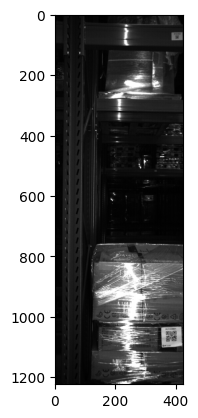

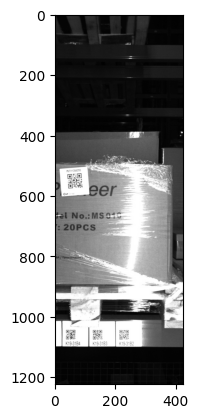

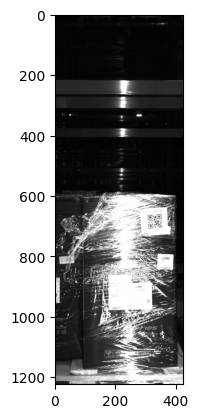

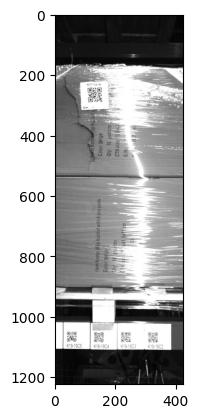

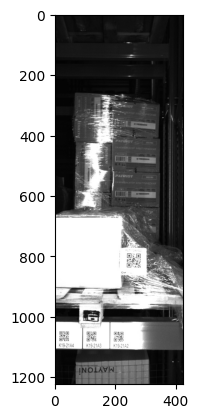

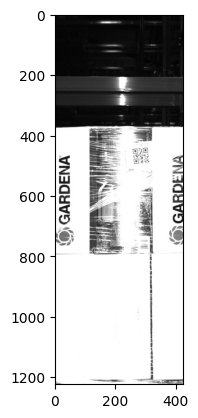

In [9]:
for it, row in enumerate(data.iterrows()):
    print_img(row[1]['jpeg_path'])
    if it == 5:
        break